In [1]:
import finnhub
import pandas as pd
from time import mktime
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Evitar errores
import warnings
warnings.filterwarnings("ignore")

In [3]:
# formato de graficas
sns.set_theme()
sns.set_context("paper")

In [4]:
# api_key de finnhub (https://finnhub.io/dashboard)
finnhub_client = finnhub.Client(api_key="ckuirj9r01qmtr8l8f40ckuirj9r01qmtr8l8f4g")

In [5]:
stock = 'AAPL' # acciones de apple
resolution = 'D' # serie diaria

end_date = datetime.now() #fecha de hoy
start_date = end_date - timedelta(days=365) # desde hoy con historia de 365

In [6]:
end = int(end_date.timestamp()) # transforma fecha final unix-time a entero
start = int(start_date.timestamp())# transforma fecha inicial unix-time a entero

AAPL_res = finnhub_client.stock_candles(stock, resolution, start, end) #respuesta 
AAPL_df = pd.DataFrame(AAPL_res) # transformar respuesta  pandas

AAPL_df.head()

,c,h,l,o,s,t,v
0,138.92,139.145,135.6710,137.11,ok,1667779200,83374628
1,139.50,141.430,137.4900,140.41,ok,1667865600,89908477
2,134.87,138.550,134.5933,138.50,ok,1667952000,74917794
3,146.87,146.870,139.5000,141.24,ok,1668038400,118854028
4,149.70,150.010,144.3700,145.82,ok,1668124800,93979665


In [7]:
# funcion que transforma fecha int a fecha humana
def date_format(date_col):
    return datetime.fromtimestamp(date_col).strftime('%Y-%m-%d')

In [8]:
date_format(1602460800)

'2020-10-11'

In [9]:
AAPL_df['t'] = AAPL_df['t'].apply(date_format) # transforma la columna t a fecha humana con la funcion 'date_format' creada
AAPL_df.head()

,c,h,l,o,s,t,v
0,138.92,139.145,135.6710,137.11,ok,2022-11-06,83374628
1,139.50,141.430,137.4900,140.41,ok,2022-11-07,89908477
2,134.87,138.550,134.5933,138.50,ok,2022-11-08,74917794
3,146.87,146.870,139.5000,141.24,ok,2022-11-09,118854028
4,149.70,150.010,144.3700,145.82,ok,2022-11-10,93979665


In [10]:
# renombrar las columnas
AAPL_df.rename(columns = {'c':'Close','h':'High','l':'Low','o':'Open','t':'Date','v':'Volume'}, inplace = True)
AAPL_df.drop('s', axis=1, inplace = True)
AAPL_df.head()

,Close,High,Low,Open,Date,Volume
0,138.92,139.145,135.6710,137.11,2022-11-06,83374628
1,139.50,141.430,137.4900,140.41,2022-11-07,89908477
2,134.87,138.550,134.5933,138.50,2022-11-08,74917794
3,146.87,146.870,139.5000,141.24,2022-11-09,118854028
4,149.70,150.010,144.3700,145.82,2022-11-10,93979665


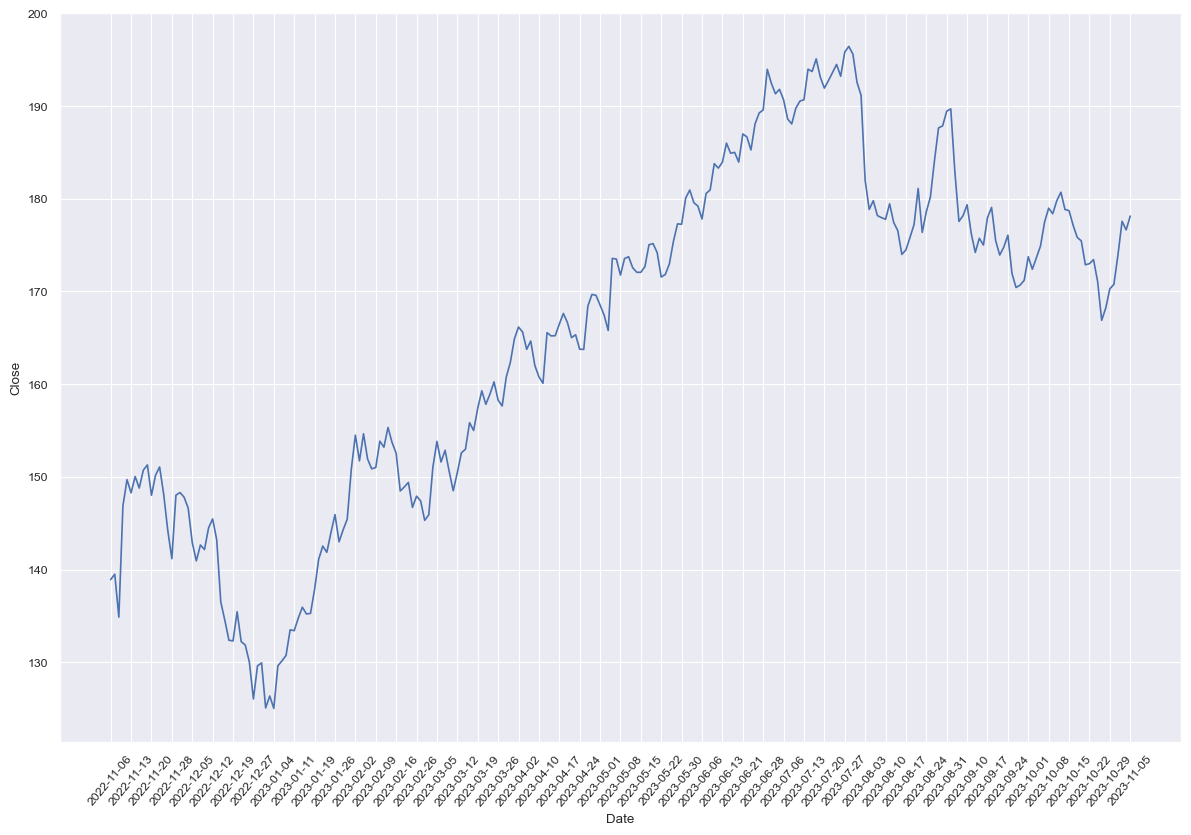

In [11]:
plt.figure(figsize = (12,8))
ax = sns.lineplot(data=AAPL_df, x="Date", y="Close")
freq = int(5)
xtix = ax.get_xticks() 
ax.set_xticks(xtix[::freq]) # evita que las etiquetas se sobrepongan
plt.tight_layout()
plt.xticks(rotation=50);

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x = AAPL_df.Date,
                                     open = AAPL_df.Open, 
                                     high = AAPL_df.High,
                                     low = AAPL_df.Low, 
                                     close = AAPL_df.Close)
                     ])
fig.update_layout(
    title="Apple Inc. (AAPL)",
    xaxis_title="Day",
    yaxis_title="AAPL-USD",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [13]:
# prueba de estacionariedad
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [14]:
result = adfuller(AAPL_df.Close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.428372
p-value: 0.568601


La accion de Apple no es estacionaria, el p-valor de la prueba mayor 0.05 no se rechaza la H0 que sugiere estacionariedad con la prueba de dicky-fuller

Valor = 0,668546 > 0,05. Dado que el valor 
 de Adfuller es mayor que un determinado valor alfa especificado (5%, nivel de significación o intervalo de confianza del 95%), se acepta la hipótesis nula 
, es decir, la serie temporal no es estacionaria

In [15]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

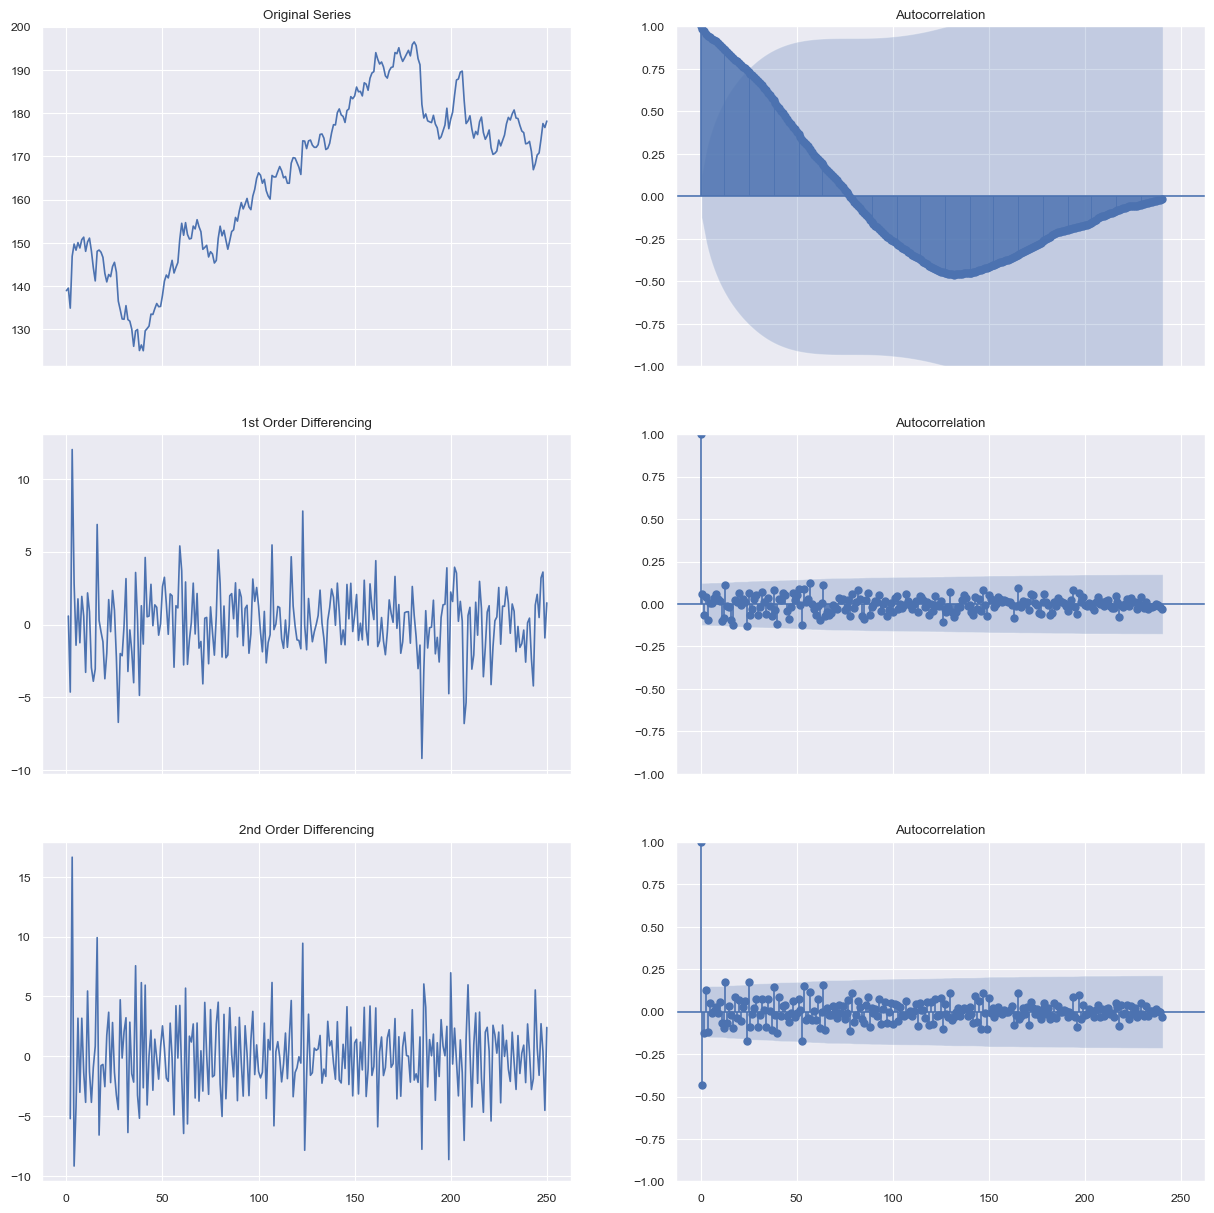

In [16]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(AAPL_df.Close); axes[0, 0].set_title('Original Series')
plot_acf(AAPL_df.Close, ax=axes[0, 1], lags = 240);

axes[1, 0].plot(AAPL_df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(AAPL_df.Close.diff().dropna(), ax=axes[1, 1], lags = 240);

axes[2, 0].plot(AAPL_df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(AAPL_df.Close.diff().diff().dropna(), ax=axes[2, 1], lags = 240);

In [33]:
n_AAPL = len(AAPL_df.Close); n_test = 28 # This can be changed
train_size = n_AAPL - n_test

train = AAPL_df.Close.iloc[:train_size]
dates_train = AAPL_df.Date.iloc[:train_size]
test_1w = AAPL_df.Close.iloc[train_size:train_size + n_test] 
dates_1w = AAPL_df.Date.iloc[train_size:train_size + n_test] 
print("train:", train.shape)
print("test_1w:", test_1w.shape)

train: (223,)
test_1w: (28,)


In [34]:
train_df = AAPL_df[["Date", "Close"]].iloc[:train_size] # enetrenamiento
test_1w_df = AAPL_df[["Date", "Close"]].iloc[train_size:train_size + n_test] # test

In [35]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [36]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5) # de 0 a 4 preciosa pasados
d_rng  = range(3) # 

for i in pq_rng: #p de ar (autor regresion)
    for d in d_rng: #i de integracion
        for j in pq_rng: #q de ma (media movil)
            try:
                # print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic: #tmp_aic inicia en infinito y se compara con cada modelo generado por ARIMA
                    best_aic = tmp_aic #toma el mejor AIC 
                    best_order = (i, d, j) #Toma los mejores parametros
                    best_mdl = tmp_mdl #toma el mejor modelo
            except: continue

In [37]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 1033.68474 | order: (3, 1, 3)


In [38]:
import pmdarima as pm

model = pm.arima.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1038.556, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1040.104, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1040.023, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1037.277, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.354 seconds


In [39]:
from statsmodels.graphics.tsaplots import plot_predict

In [40]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()

<Figure size 1200x800 with 0 Axes>

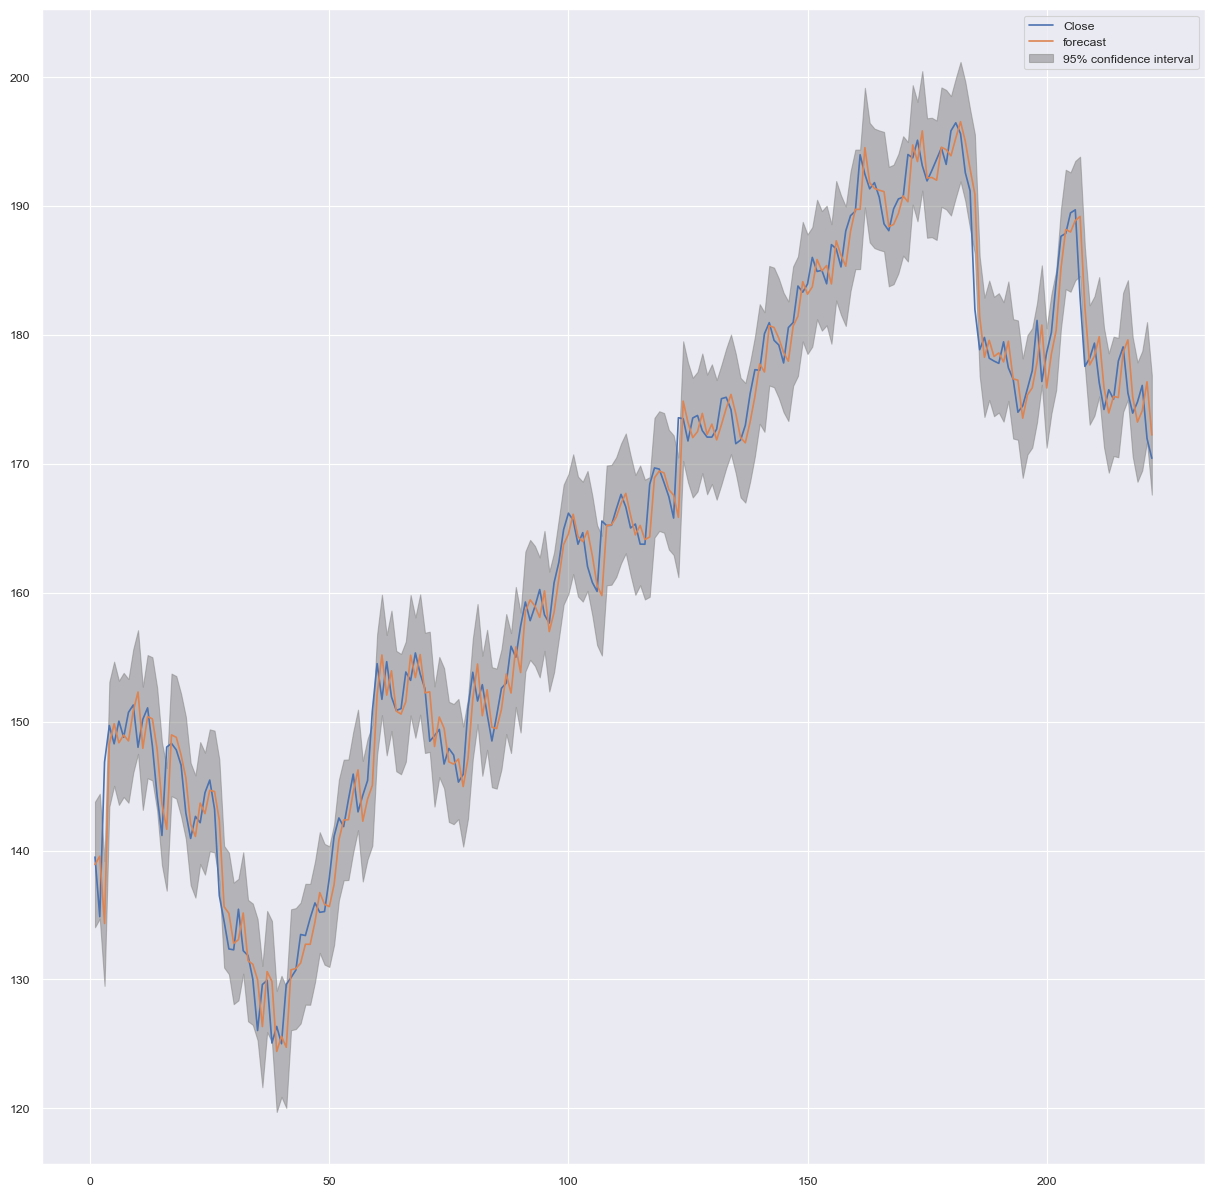

In [41]:
plt.figure(figsize = (12,8))
fig, ax = plt.subplots()
ax = train.loc[1:].plot(ax=ax)
plot_predict(model_fit, 1, ax=ax)
plt.show();

In [42]:
from sklearn.metrics import r2_score

In [43]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [44]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [45]:
test_1wl = test_1w.tolist()
yhat_1w  = arima_rolling(train.tolist(), test_1wl)

predicted=171.082662, expected=170.690000
predicted=170.317369, expected=171.210000
predicted=172.077527, expected=173.750000
predicted=173.748767, expected=172.400000
predicted=172.545135, expected=173.660000
predicted=173.019581, expected=174.910000
predicted=174.854465, expected=177.490000
predicted=176.737343, expected=178.990000
predicted=178.566310, expected=178.390000
predicted=178.115744, expected=179.800000
predicted=180.204808, expected=180.710000
predicted=180.571663, expected=178.850000
predicted=179.330338, expected=178.720000
predicted=179.078779, expected=177.150000
predicted=177.407551, expected=175.840000
predicted=175.733880, expected=175.460000
predicted=175.091046, expected=172.880000
predicted=172.907070, expected=173.000000
predicted=173.368352, expected=173.440000
predicted=173.408746, expected=171.100000
predicted=170.775895, expected=166.890000
predicted=166.374213, expected=168.220000
predicted=167.966331, expected=170.290000
predicted=169.435144, expected=170

In [46]:
forecast_accuracy(np.array(test_1wl), np.array(yhat_1w), "week 1")

,MAE,MSE,MAPE,RMSE,R2
week 1,1.631794,3.790933,0.0094,1.947032,0.706585


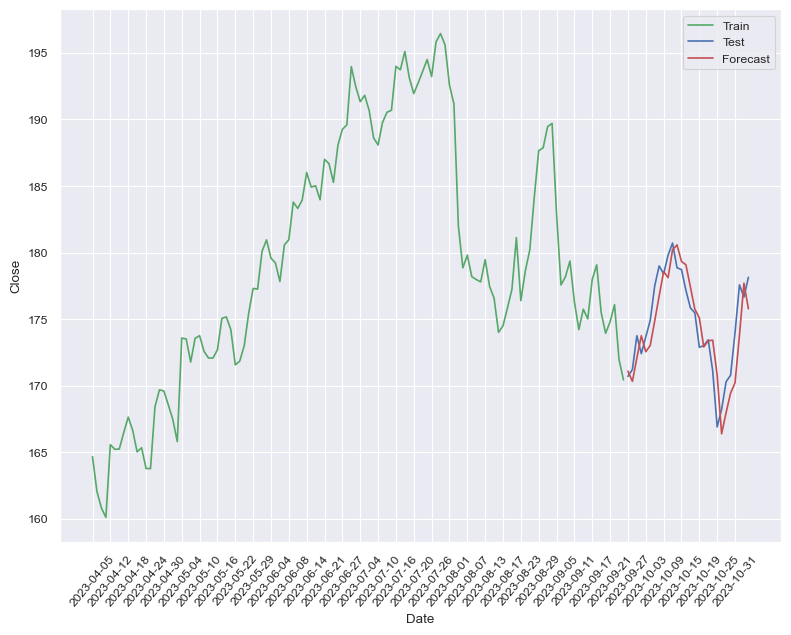

In [47]:
plt.figure(figsize = (8, 6))
ax = sns.lineplot(x=dates_train[-120:], y=train[-120:], label="Train", color='g')
sns.lineplot(x=dates_1w, y=test_1wl, label="Test", color='b')
sns.lineplot(x=dates_1w, y=yhat_1w, label="Forecast", color='r')
freq = int(4)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
plt.tight_layout()
plt.xticks(rotation=50);